In [457]:
import numpy as np
def readstdgeometry(inputgeo):
    f = open(inputgeo,'r')
    lines = f.readlines()
    stdgeo = []
    for line in lines:
        tmp = line.split(" ")[0:-1]
        if tmp[0] == 'CA': tmp.append(int(0)); stdgeo.append(tmp)
        elif tmp[0] == 'C': tmp.append(int(1)); stdgeo.append(tmp)
        elif tmp[0] == 'M': tmp.append(int(2)); stdgeo.append(tmp)
        elif tmp[0] == 'F': tmp.append(int(3)); stdgeo.append(tmp)
        elif tmp[0] == 'I': tmp.append(int(4)); stdgeo.append(tmp)
        elif tmp[0] == 'L': tmp.append(int(5)); stdgeo.append(tmp)
        elif tmp[0] == 'V': tmp.append(int(6)); stdgeo.append(tmp)
        elif tmp[0] == 'W': tmp.append(int(7)); stdgeo.append(tmp)
        elif tmp[0] == 'Y': tmp.append(int(8)); stdgeo.append(tmp)
        elif tmp[0] == 'A': tmp.append(int(9)); stdgeo.append(tmp)
        elif tmp[0] == 'G': tmp.append(int(10)); stdgeo.append(tmp)
        elif tmp[0] == 'T': tmp.append(int(11)); stdgeo.append(tmp)
        elif tmp[0] == 'S': tmp.append(int(12)); stdgeo.append(tmp)
        elif tmp[0] == 'Q': tmp.append(int(13)); stdgeo.append(tmp)
        elif tmp[0] == 'N': tmp.append(int(14)); stdgeo.append(tmp)
        elif tmp[0] == 'E': tmp.append(int(15)); stdgeo.append(tmp)
        elif tmp[0] == 'D': tmp.append(int(16)); stdgeo.append(tmp)
        elif tmp[0] == 'H': tmp.append(int(17)); stdgeo.append(tmp)
        elif tmp[0] == 'R': tmp.append(int(18)); stdgeo.append(tmp)
        elif tmp[0] == 'K': tmp.append(int(19)); stdgeo.append(tmp)
        elif tmp[0] == 'P': tmp.append(int(20)); stdgeo.append(tmp)
    stdgeo.sort(key = lambda i: i[5])
    for row in stdgeo:
        del row[0]
        del row[4]
    stdgeo = [[float(i) for i in j] for j in stdgeo]
    stdgeo = np.array(stdgeo)
    return stdgeo

In [458]:
import math
def nextCA(lastCA,llastCA,lastSC,phi):
    vector1 = np.cross(lastCA-llastCA,lastSC-lastCA)
    if np.linalg.norm(vector1)>0: vector1 = vector1/np.linalg.norm(vector1)
    vector2 = np.cross(vector1,lastCA-llastCA)
    if np.linalg.norm(vector2)>0: vector2 = vector2/np.linalg.norm(vector2)
    tmp =  math.cos(phi)*3.8*vector2 + math.sin(phi)*3.8*vector1
    if phi == 0:
        phi = 2*(np.random.random_sample()-0.5)*math.pi
        vector1 = llastCA - lastCA
        vector2 = np.array([1,1,-(vector1[0]+vector1[1])/vector1[2]])
        vector2 = vector2/np.linalg.norm(vector2)
        vector3 = np.cross(vector2,vector1)
        vector3 = vector3/np.linalg.norm(vector3)
        tmp =  math.cos(math.pi/3)*3.8*vector2 + math.sin(math.pi/3)*3.8*vector3
    return lastCA + tmp
    

def nextSC(CA,lastCA,lastSC,gamma,bsc,tsc):
    vector1 = lastCA - CA
    vector2 = np.cross(vector1,lastSC-lastCA)
    vector3 = np.cross(vector1,vector2)
    
    vector4 = bsc*math.cos(tsc)*(vector1/3.8)
    if np.linalg.norm(vector2)>0: 
        vector2 = vector2/np.linalg.norm(vector2)
    if np.linalg.norm(vector3)>0: 
        vector3 = vector3/np.linalg.norm(vector3)
    return CA + vector4 + bsc*math.sin(tsc)*(math.cos(gamma)*vector3 + math.sin(gamma)*vector2)


def transtocoord(gammalist,geometrylist,bsclist,tsclist,philist,recenter = False,C1A = np.array([0.0,0.0,0.0])):
    coord = np.zeros((len(geometrylist),3))
    
    if geometrylist[1] == 10:
        coord[0] = C1A
        coord[1] = C1A
        coord[3] = np.array([3.8,0.0,0.0]) 
        coord[2] = 0.5*(coord[3] + coord[1])
        
        coord[4] = coord[3] + np.array([-bsclist[geometrylist[4]]*math.cos(tsclist[geometrylist[4]]),\
                                    bsclist[geometrylist[4]]*math.sin(tsclist[geometrylist[4]]),0])

        coord[6] = nextCA(coord[3],coord[0],coord[4],philist[geometrylist[4]])
        coord[5] = 0.5*(coord[3]+coord[6])
        start = 7
        gammaid = 0
        
    else:
        coord[0] = C1A
        coord[2] = np.array([3.8,0.0,0.0]) 
        coord[1] = 0.5*(coord[2]+coord[0])
        #print(tsclist[geometrylist[3]])
        coord[3] = coord[2] + np.array([-bsclist[geometrylist[3]]*math.cos(tsclist[geometrylist[3]]),\
                                    bsclist[geometrylist[3]]*math.sin(tsclist[geometrylist[3]]),0])
        coord[5] = nextCA(coord[2],coord[0],coord[3],philist[geometrylist[3]])
        coord[4] = 0.5*(coord[2] + coord[5])
        start = 6
        gammaid = 0
    
    for i in range(start,len(geometrylist)-1,3):
        coord[i] = nextSC(coord[i-1],coord[i-4],coord[i-3],\
                          gammalist[gammaid],bsclist[geometrylist[i]],tsclist[geometrylist[i]])
        coord[i+2] = nextCA(coord[i-1],coord[i-4],coord[i],philist[geometrylist[i]])
        coord[i+1] = 0.5*(coord[i-1]+coord[i+2])
        gammaid = gammaid + 1
    
    if geometrylist[len(geometrylist)-1] == 10: coord[len(geometrylist)-1] = coord[-2]
    
    if recenter==True:
        geometrycenter = np.sum(coord,axis = 0)
        coord = coord - geometrycenter
    return coord

In [459]:
def initialize(inputfasta,inputgeo):
    f = open(inputfasta,'r')
    lines = f.readline()
    seq_list = []
    for line in lines:
        print(line)
        if line == 'C': seq_list.append(int(1))
        elif line == 'M': seq_list.append(int(2))
        elif line == 'F': seq_list.append(int(3))
        elif line == 'I': seq_list.append(int(4))
        elif line == 'L': seq_list.append(int(5))
        elif line == 'V': seq_list.append(int(6))
        elif line == 'W': seq_list.append(int(7))
        elif line == 'Y': seq_list.append(int(8))
        elif line == 'A': seq_list.append(int(9))
        elif line == 'G': seq_list.append(int(10))
        elif line == 'T': seq_list.append(int(11))
        elif line == 'S': seq_list.append(int(12))
        elif line == 'Q': seq_list.append(int(13))
        elif line == 'N': seq_list.append(int(14))
        elif line == 'E': seq_list.append(int(15))
        elif line == 'D': seq_list.append(int(16))
        elif line == 'H': seq_list.append(int(17))
        elif line == 'R': seq_list.append(int(18))
        elif line == 'K': seq_list.append(int(19))
        elif line == 'P': seq_list.append(int(20))
        elif line == '\n': print("Sequence succesfully read")
        else: 
            print('Residue cannot be recognized, please check...') 
            exit()

    geometry_list = []
    interaction_list = []
    
    if seq_list[0] == 10: 
        geometry_list.extend([0,10,21])
        interaction_list.extend([0,10,21])
    else: #add dummpy residue when end residue is not GLY
        geometry_list.extend([0,21,0,seq_list[0],21]) #0 represent only Ca
        interaction_list.extend([0,0,0,seq_list[0],21]) #0 represent Ca and dummy p
        
    for i in range(1,len(seq_list)-1):
        geometry_list.extend([0,seq_list[i],21])
        interaction_list.extend([0,seq_list[i],21])
        
    if seq_list[len(seq_list)-1] == 10:
        geometry_list.extend([0,10])
        interaction_list.extend([0,10])
    else: #add dummpy residue when end residue is not GLY
        geometry_list.extend([0,seq_list[len(seq_list)-1],21,0])
        interaction_list.extend([0,seq_list[len(seq_list)-1],0,0])
    
    seq_list = np.array(seq_list)
    geometry_list = np.array(geometry_list)
    interaction_list = np.array(interaction_list)
    #initial torsion angles (this are are degree of freedoms used in the force field, instead of the coordinates)
    gamma_list = np.zeros(np.count_nonzero(geometry_list==0)-3) #number of torsion angle gamma should be n(CA) -3
    gamma_list[::2]= math.pi
    

    standardgeo = readstdgeometry(inputgeo)
    bsclist = standardgeo[:,0]
    tsclist = standardgeo[:,1]*(math.pi/180.0)
    philist = standardgeo[:,2]*(math.pi/180.0)

    
    coord_list = transtocoord(gamma_list,geometry_list,bsclist,tsclist,philist)
    return seq_list, geometry_list, interaction_list, gamma_list, coord_list, bsclist, tsclist, philist

           

In [460]:
seq_list,geometry_list,interaction_list,gamma_list,coord_list,\
     bsclist, tsclist, philist = initialize('ahelixtest3.fasta','standard_geometry.str')

T
P
R
Q
A
R
A
A
R
A
A
C


Sequence succesfully read


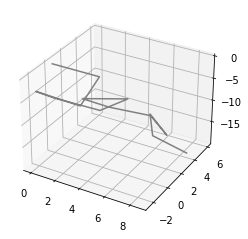

In [461]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes(projection='3d')
coord_list_CA = coord_list[geometry_list == 0]
ax.plot3D(coord_list_CA[:,0], coord_list_CA[:,1], coord_list_CA[:,2], 'gray')
np.savetxt("initiala1.txt",coord_list,fmt = '% 8.3f % 8.3f % 8.3f')

In [462]:
def get_SCSC_parameter(MJparameterfile,r0parameterfile,interactionlist,egg=0.025): #egg means epsilon(GLY,GLY)
    
    #first, import MJ contact energies and van der waals radii
    MJlist = np.loadtxt(MJparameterfile)
    for i in range(1,MJlist.shape[0]):
        for j in range(0,i):
            MJlist[i,j] = MJlist[j,i]
    r0list = np.loadtxt(r0parameterfile)
    
    #second, calculate r0ij 
    SClist = interactionlist[(interactionlist<21) & (interactionlist > 0)]
    r0ij = np.zeros((len(SClist),len(SClist)))
    for i in range(len(SClist)):
        for j in range(len(SClist)):
            r0ij[i,j] = r0list[SClist[i]-1] + r0list[SClist[j]-1]
    r0ij = r0ij/2.0
    
    #third, calculate eij for the interaction list
    eMJij = np.zeros((len(SClist),len(SClist)))
    fij = np.ones((len(SClist),len(SClist)))
    
    for i in range(len(SClist)):
        for j in range(len(SClist)):
            eMJij[i,j] = MJlist[SClist[i]-1,SClist[j]-1]
            if SClist[i] == 20 and SClist[j] == 20: fij[i,j] = 0.41
            elif SClist[i] == 20 and SClist[j] != 20: fij[i,j] = 0.79
            elif SClist[j] == 20 and SClist[i] != 20: fij[i,j] = 0.79
            else: continue
    print(MJlist[9,9])
    eij = 0.6 * (eMJij - fij*MJlist[9,9])
    for i in range(len(SClist)):
        for j in range(len(SClist)):
            if SClist[i] == 10 and SClist[j] == 10: eij[i,j] = egg 
                
    eij[np.diag_indices(len(SClist))] = 0.0
    eij_hypho = np.copy(eij)
    eij_hypho[eij_hypho > 0] = 0.0
    eij_hyphi = np.copy(eij)
    eij_hyphi[eij_hyphi < 0] = 0.0
    
    return MJlist, r0ij, eij_hypho, eij_hyphi

def potential_SCSC(MJlist,r0ij,interactionlist,coord,eij_hypho,eij_hyphi,rc):
    SCcoord = coord[(interactionlist<21) & (interactionlist > 0)] #correspond to the SClist
    SC_displacements = SCcoord[:,np.newaxis,:] - SCcoord[np.newaxis,:,:]
    #SC_displacements = minimum_image(SC_displacements, L)
    rSC = np.linalg.norm(SC_displacements, axis=-1)
    rSC[np.diag_indices(len(rSC))] = np.inf
    
    tmp = np.power(r0ij/rSC,6)
    v_hypho = -eij_hypho*tmp*(tmp-2.0) #v_hypho = eij_hypho*tmp*(tmp-2.0)
    v_hyphi = eij_hyphi*(tmp) #v_hyphi = -eij_hyphi*(tmp)
    #print(v_hypho.shape,v_hyphi.shape)
    
    tmp2 = np.power(r0ij/rc,6)
    vc_hypho = -eij_hypho*tmp2*(tmp2-2.0) #vc_hypho = eij_hypho*tmp2*(tmp2-2.0)
    #print(eij_hypho)
    vc_hyphi = eij_hyphi*(tmp2) #vc_hyphi = -eij_hyphi*(tmp2)
    #print("vc_hypho",vc_hypho)
    #print("vc_hyphi",vc_hyphi)
    v_hypho[rSC < rc] -= vc_hypho[rSC < rc] #shift
    v_hypho[rSC >= rc] = 0 #cut
    v_hyphi[rSC < rc] -= vc_hyphi[rSC < rc]  #shift
    v_hyphi[rSC >= rc] = 0 #cut
    
    return 0.5*np.sum(v_hypho+v_hyphi)

In [463]:
def get_torsion_parameter(torsionparameter,interactionlist):
    parameterlist = np.loadtxt(torsionparameter)
    alist = parameterlist[:, 0::2]
    blist = parameterlist[:, 1::2]
    SCindex = np.array(np.where(geometry_list == 0))[0][1:-1] + 1 #get rid of the SCs on two ends if there are 
    SClist = interactionlist[SCindex.tolist()]
    alist_for_link = np.zeros((len(SClist)-1,6))
    blist_for_link = np.zeros((len(SClist)-1,6))
    
    for i in range(len(SClist)-1):
        tmpbefore = SClist[i]
        tmpnext = SClist[i+1]
        if tmpbefore == 10:
            if tmpnext == 10: alist_for_link[i] = alist[0]; blist_for_link[i] = blist[0]
            elif tmpnext == 20: alist_for_link[i] = alist[6]; blist_for_link[i] = blist[6]
            else: alist_for_link[i] = alist[3]; blist_for_link[i] = blist[3]
        elif tmpbefore == 20:
            if tmpnext == 10: alist_for_link[i] = alist[2]; blist_for_link[i] = blist[2]
            elif tmpnext == 20: alist_for_link[i] = alist[8]; blist_for_link[i] = blist[8]
            else: alist_for_link[i] = alist[5]; blist_for_link[i] = blist[5]
        else:
            if tmpnext == 10: alist_for_link[i] = alist[1]; blist_for_link[i] = blist[1]
            elif tmpnext == 20: alist_for_link[i] = alist[7]; blist_for_link[i] = blist[7]
            else: alist_for_link[i] = alist[4]; blist_for_link[i] = blist[4]
            
    return alist_for_link, blist_for_link

def potential_torsion(gammalist,alist_for_link,blist_for_link):
    gammamap= np.array(np.tile(gammalist,(6,1))).transpose()
    #print(gammamap)
    tmp = gammamap * np.tile(np.array(range(1,7)),(len(gammalist),1))
    #print(tmp)
    p = np.sum(alist_for_link*np.cos(tmp) + blist_for_link*np.sin(tmp))#use pi
    return p

In [464]:
def get_SCP_parameter(interactionlist):
    SCindex = np.where((interactionlist > 0) & (interactionlist < 21))[0]
    Pindex = np.where(interactionlist == 21)[0]
    SCPdistance = SCindex[:,np.newaxis] - Pindex[np.newaxis,:]
    SCPdistance = np.abs(SCPdistance)
    SCPmask = np.ones(SCPdistance.shape)
    SCPmask[(SCPdistance == 1) | (SCPdistance == 2)] = 0.0
    print(SCPmask.shape)
    return SCPmask

def potential_SCP(interactionlist,coord,SCPmask,rscp=4.0,escp=0.3):
    SCcoord = coord[(interactionlist>0) & (interactionlist<21)]
    Pcoord = coord[(interactionlist==21)]
    SCP_displacements = SCcoord[:,np.newaxis,:] - Pcoord[np.newaxis,:,:]
    rSCP = np.linalg.norm(SCP_displacements, axis=-1)
    v = np.power(rSCP, -6)*SCPmask
    return escp*np.power(rscp,6)*np.sum(v)

In [465]:
def get_PP_parameter(interactionlist,PPparameterfile):
    pp_parameter = np.loadtxt(PPparameterfile)
    ep = pp_parameter[:,0]
    rp = pp_parameter[:,1]
    A = pp_parameter[:,2]
    B = pp_parameter[:,3]
    
    valid_SClist = []
    for i in range(0,len(interactionlist)):
        if interactionlist[i] == 21: 
            valid_SClist.append(interactionlist[i-1])  #do not include P in the end !
        else: 
            continue
            
    valid_SClist = np.array(valid_SClist)
    n = len(valid_SClist)
    Aij = A[0]*np.ones((n,n))
    Bij = B[0]*np.ones((n,n))
    rpij = rp[0]*np.ones((n,n))
    epij = ep[0]*np.ones((n,n))

    op_index = np.asarray(np.where(valid_SClist==20)[0])
    if len(op_index) != 0: 
        for i in op_index:
            Aij[i,:] =  A[1]*np.ones(n)
            Aij[:,i] =  A[1]*np.ones(n)
            Bij[i,:] =  B[1]*np.ones(n)
            Bij[:,i] =  B[1]*np.ones(n)
            rpij[i,:] =  rp[1]*np.ones(n)
            rpij[:,i] =  rp[1]*np.ones(n)
            epij[i,:] =  ep[1]*np.ones(n)
            epij[:,i] =  ep[1]*np.ones(n)
        if len(op_index) >= 2:
            for j in op_index:
                for k in op_index:
                    Aij[j,k] =  A[2]; Aij[k,j] =  A[2]
                    Bij[j,k] =  B[2]; Bij[k,j] =  B[2]
                    rpij[j,k] = rp[2]; rpij[k,j] = rp[2]
                    epij[j,k] = ep[2]; epij[k,j] = ep[2]
                    
    Aij[np.diag_indices(n)] = 0.0
    Bij[np.diag_indices(n)] = 0.0
    rpij[np.diag_indices(n)] = 0.0
    epij[np.diag_indices(n)] = 0.0
    
    tmp = np.asarray(np.where(interactionlist == 21)[0])
    Cabeforelist = [i - 2 for i in tmp]
    Caafterlist = [i + 1 for i in tmp]
    Plist = [i for i in tmp]
    
    Pindex = np.array(range(len(Plist)))
    PPdistance = Pindex[:,np.newaxis] - Pindex[np.newaxis,:]
    PPdistance = np.abs(PPdistance)
    PPmask = np.ones(PPdistance.shape)
    PPmask[(PPdistance == 1) | (PPdistance == 0)] = 0.0
    
    return Aij, Bij, rpij, epij, Cabeforelist, Caafterlist, Plist, PPmask



def potential_PP(Aij,Bij,rpij,epij,coord,Cabeforelist,Caafterlist,Plist,PPmask):
    Cabefore_coord = coord[Cabeforelist]
    Caafter_coord = coord[Caafterlist]
    P_coord = coord[Plist]
    
    v = Caafter_coord - Cabefore_coord
    aij = np.sum(v[:,np.newaxis,:] * v[np.newaxis,:,:],axis = 2) 
    rij_disp = P_coord[:,np.newaxis,:] - P_coord[np.newaxis,:,:]
   
    bij = np.sum(v[:,np.newaxis,:] * rij_disp,axis = 2) #already includes cos() here !
    gij = -bij.transpose()
    rij = np.linalg.norm(rij_disp,axis = -1)  #aij, bij and gij are all before normalization
    rij[np.diag_indices(rij.shape[0])] = np.inf
    #print(rij)

    tmp1 = np.power(rij,-6)
    tmp2 = np.power(3.8, -2)*(aij - 3*bij*gij/(rij**2))
    tmp3 = np.power(rpij/rij, 6)
    
    p = Aij*np.power(rij,-3)*tmp2\
       - Bij*tmp1*(4 + tmp2**2 -3*(bij**2 + gij**2)/((rij**2)*(3.8**2)))\
       + epij*tmp3*(tmp3 - 2.0)
    
    p = p * PPmask
    return np.sum(0.5*p)


In [466]:
import scipy.stats as ss

def rn_generator(n,st):
    if n%2 != 0:
        m = int(n/2)
        x = np.arange(-m, m+1) 
        xU, xL = x + 0.5, x - 0.5 
        prob = ss.norm.cdf(xU, scale = m) - ss.norm.cdf(xL, scale = m)
        prob = prob / prob.sum() #normalize the probabilities so their sum is 1
        nums = np.random.choice(x, size = st, p = prob) + m
    else:
        m = int(n/2) 
        x = np.arange(-m, m) 
        xU, xL = x + 0.5, x - 0.5 
        prob = ss.norm.cdf(xU, scale = m) - ss.norm.cdf(xL, scale = m)
        prob = prob / prob.sum() #normalize the probabilities so their sum is 1
        nums = np.random.choice(x, size = st, p = prob) + m
    return nums

In [467]:
def classic_calculate_A(beta,delta_pot):
    tmp = np.exp(-delta_pot*beta)
    if tmp >= 1.0:
        return 1.0
    else:
        return tmp
    
def MC_trail(beta, propose_index, gammalist,geometrylist,interactionlist,coord, MJlist, r0ij, rc, \
             bsclist, tsclist, philist,eij_hypho, eij_hyphi,SCPmask,\
             Aij,Bij,rpij,epij,Cabeforelist,Caafterlist,Plist,PPmask, alist_for_link, blist_for_link, old_pot):
    
    trial_move = np.random.normal(0,math.pi/18,1) #(np.random.uniform(0, 1) - 0.5)*2*math.pi/18
    propose_gammalist = np.copy(gammalist)
    propose_gammalist[propose_index] = propose_gammalist[propose_index] + trial_move
    newcoord = transtocoord(propose_gammalist,geometrylist,bsclist,tsclist,philist)
    
    p1 = potential_SCP(interactionlist,newcoord,SCPmask)
    p2 = potential_SCSC(MJlist,r0ij,interactionlist,newcoord,eij_hypho,eij_hyphi,rc)
    p3 = potential_PP(Aij,Bij,rpij,epij,newcoord,Cabeforelist,Caafterlist,Plist,PPmask)
    p4 = potential_torsion(propose_gammalist, alist_for_link, blist_for_link)
    
    new_pot = p2 + p4 + p1 + p3

    A = classic_calculate_A(beta,new_pot - old_pot)
    return propose_gammalist, newcoord, new_pot, A, p1, p2, p3, p4

In [468]:
import time
start_time = time.time()

rc = 120.0
MJlist, r0ij, eij_hypho, eij_hyphi = get_SCSC_parameter('parameterMJ.prm','r0.prm',interaction_list)
SCPmask = get_SCP_parameter(interaction_list)
Aij, Bij, rpij, epij, Cabeforelist, Caafterlist, Plist, PPmask = get_PP_parameter(interaction_list,'parameterpp.prm')
alist_for_link, blist_for_link = get_torsion_parameter('parametertorsion.prm',interaction_list)

beta = 1.0/0.593 #298K

record_coord = []
record_gamma = []
record_energy =[]
record_P1 = []
record_P2 = []
record_P3 = []
record_P4 = []

p1 = potential_SCP(interaction_list,coord_list,SCPmask)
p2 = potential_SCSC(MJlist,r0ij,interaction_list,coord_list,eij_hypho,eij_hyphi,rc)
p3 = potential_PP(Aij,Bij,rpij,epij,coord_list,Cabeforelist,Caafterlist,Plist,PPmask)
p4 = potential_torsion(gamma_list, alist_for_link, blist_for_link)

oldpot = p1 + p2 + p4 + p3

record_coord.append(coord_list)
record_gamma.append(gamma_list)
record_energy.append(oldpot)
record_P1.append(p1)
record_P2.append(p2)
record_P3.append(p3)
record_P4.append(p4)

acceptance = 0
totalts = 50000*len(gamma_list) 

for ts in range(50000):
    for i in range(len(gamma_list)):
        newgammalist, newpos, newpot, A, pp1, pp2, pp3, pp4 = MC_trail(beta, i, gamma_list,geometry_list,interaction_list,coord_list, \
             MJlist, r0ij, rc, bsclist, tsclist, philist,eij_hypho, eij_hyphi,SCPmask,\
             Aij,Bij,rpij,epij,Cabeforelist,Caafterlist,Plist,PPmask, alist_for_link, blist_for_link, oldpot)
        
        rn = np.random.random_sample()
        if rn < A:
            gamma_list = newgammalist
            coord_list = newpos
            oldpot = newpot
            acceptance = acceptance + 1
            p1 = pp1
            p2 = pp2
            p3 = pp3
            p4 = pp4
            
        else:
            continue
        
    if ts%10 == 0: 
        record_coord.append(coord_list)
        record_gamma.append(gamma_list)
        record_energy.append(oldpot)
        record_P1.append(p1)
        record_P2.append(p2)
        record_P3.append(p3)
        record_P4.append(p4)
    if ts%100 == 0:
        print("--- %d steps %s seconds ---" % (ts, time.time() - start_time))
        print(newpot)


-2.17
(12, 11)
--- 0 steps 0.19168400764465332 seconds ---
1090.651042260842
--- 100 steps 8.644299983978271 seconds ---
-23.861452417444152
--- 200 steps 14.252731800079346 seconds ---
-27.410204380343615
--- 300 steps 18.99239492416382 seconds ---
-28.864598274983635
--- 400 steps 23.37870478630066 seconds ---
-30.554024123487814
--- 500 steps 28.0609610080719 seconds ---
-26.652291570425387
--- 600 steps 32.46371388435364 seconds ---
-26.64625441141956
--- 700 steps 36.87305808067322 seconds ---
-28.650770972973493
--- 800 steps 41.729251861572266 seconds ---
-24.660360807305672
--- 900 steps 46.16917872428894 seconds ---
-26.16304783301638
--- 1000 steps 51.8516788482666 seconds ---
-26.317991392841584
--- 1100 steps 56.61397695541382 seconds ---
-27.190722247455067
--- 1200 steps 62.02925205230713 seconds ---
-24.269993240343062
--- 1300 steps 66.6268846988678 seconds ---
-25.684175761447
--- 1400 steps 71.99631690979004 seconds ---
-26.719701031261565
--- 1500 steps 76.7352046966

--- 12700 steps 683.0016298294067 seconds ---
-32.00856485132701
--- 12800 steps 688.9157917499542 seconds ---
-34.708685589732575
--- 12900 steps 694.8228039741516 seconds ---
-36.229032164988716
--- 13000 steps 699.8120889663696 seconds ---
-36.045843322429846
--- 13100 steps 704.7162828445435 seconds ---
-31.80034693971764
--- 13200 steps 709.2852118015289 seconds ---
-33.08783753420488
--- 13300 steps 714.7391180992126 seconds ---
-35.64448948901084
--- 13400 steps 722.4376230239868 seconds ---
-33.00204344906712
--- 13500 steps 726.8538439273834 seconds ---
-32.613840054366506
--- 13600 steps 737.0131938457489 seconds ---
-31.46249859344304
--- 13700 steps 744.7488889694214 seconds ---
-33.09502932125685
--- 13800 steps 751.153294801712 seconds ---
-34.49012946109178
--- 13900 steps 757.0193889141083 seconds ---
-34.728799526234305
--- 14000 steps 761.9859178066254 seconds ---
-35.27345824085432
--- 14100 steps 766.5024130344391 seconds ---
-34.37567361991211
--- 14200 steps 771.1

--- 25200 steps 1311.0506398677826 seconds ---
-35.82212082256538
--- 25300 steps 1319.4931907653809 seconds ---
-35.87701915567136
--- 25400 steps 1325.0864498615265 seconds ---
-33.89449543183814
--- 25500 steps 1329.785978794098 seconds ---
-32.3772164838244
--- 25600 steps 1334.4255857467651 seconds ---
-37.38946607322417
--- 25700 steps 1339.3550338745117 seconds ---
-36.862789292830136
--- 25800 steps 1346.09410572052 seconds ---
-36.050503963628515
--- 25900 steps 1351.776594877243 seconds ---
-33.97074878081888
--- 26000 steps 1356.9023699760437 seconds ---
-32.64031697923055
--- 26100 steps 1362.2297410964966 seconds ---
-33.75440189672486
--- 26200 steps 1369.0528478622437 seconds ---
-35.429416530311116
--- 26300 steps 1374.5749907493591 seconds ---
-31.83353017739953
--- 26400 steps 1380.6412689685822 seconds ---
-31.22846849818253
--- 26500 steps 1386.0682837963104 seconds ---
-32.319194261118824
--- 26600 steps 1391.1902787685394 seconds ---
-33.26931917002572
--- 26700 s

--- 37700 steps 1948.3832738399506 seconds ---
-34.42870058070004
--- 37800 steps 1953.2506380081177 seconds ---
-32.68405215447784
--- 37900 steps 1963.5556757450104 seconds ---
-32.84369508222797
--- 38000 steps 1973.3975858688354 seconds ---
-35.01326013782074
--- 38100 steps 1981.8289530277252 seconds ---
-34.64850939621096
--- 38200 steps 1988.0515377521515 seconds ---
-32.759578632120174
--- 38300 steps 1993.3893597126007 seconds ---
-33.311455633159014
--- 38400 steps 1998.4649257659912 seconds ---
-26.623529893651565
--- 38500 steps 2003.3618450164795 seconds ---
-35.82423680399138
--- 38600 steps 2008.3984770774841 seconds ---
-34.24157810408413
--- 38700 steps 2012.9565529823303 seconds ---
-33.477429786326475
--- 38800 steps 2017.5055108070374 seconds ---
-36.02441812709221
--- 38900 steps 2022.6670978069305 seconds ---
-34.71834522417531
--- 39000 steps 2028.6715607643127 seconds ---
-32.96118308042864
--- 39100 steps 2033.5859858989716 seconds ---
-33.065083067920604
--- 3

In [479]:
print(acceptance/totalts)
min_energy_index = np.where(record_energy == np.min(record_energy))[0]
np.save('record_coorda1.npy', record_coord)
np.save('record_gammaa1.npy', record_gamma)
np.save('record_energy.npy', record_energy)
np.save('record_p1.npy',record_P1)
np.save('record_p2.npy',record_P2)
np.save('record_p3.npy',record_P3)
np.save('record_p4.npy',record_P4)

0.6350690909090909


In [471]:
min_energy_index = np.where(record_energy == np.min(record_energy))[0][0]
print(min_energy_index)
coord_with_min_energy = record_coord[min_energy_index]
np.savetxt("structurea1.txt",coord_with_min_energy,fmt = '% 8.3f % 8.3f % 8.3f')

626


In [ ]:
coord_initial = record_coord[0]
np.savetxt("initiala1.txt",coord_initial,fmt = '% 8.3f % 8.3f % 8.3f')

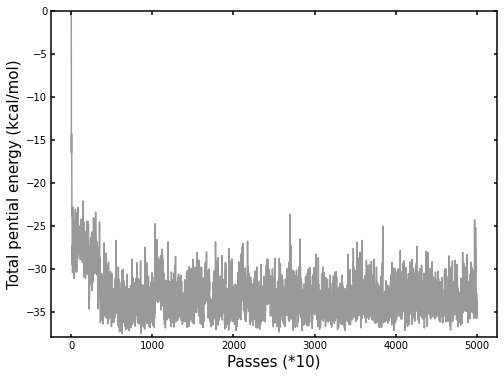

In [477]:
fig = plt.figure(figsize=(8,6))
ax = fig.gca()
ax.tick_params(which='both',top='on',left = 'on', right = 'on', bottom ='on',direction='in',width = 1.5)
ax.spines["right"].set_linewidth(1.5)
ax.spines["left"].set_linewidth(1.5)
ax.spines["top"].set_linewidth(1.5)
ax.spines["bottom"].set_linewidth(1.5)
plt.plot(record_energy,alpha = 0.4, color = 'k')
plt.ylim([-38,0])
plt.xlabel('Passes (*10)',fontsize = 15)
plt.ylabel("Total pential energy (kcal/mol)", fontsize = 15)
plt.savefig('figure2.1.pdf')

In [474]:
def my_var(dataset):
    n = len(dataset)
    ave = np.mean(dataset)
    var = np.sum((dataset-ave)**2)
    var = var/(n-1)
    return var
def coeff(s,lag):
    n = len(s)
    ave = np.mean(s)
    tmp1 = np.array(s[0:n-lag])-ave
    tmp2 = np.array(s[lag:n])-ave
    v = my_var(s)
    return np.dot(tmp1,tmp2)/((n-lag)*v)
def my_actime(a): 
    lags = range(1,len(a)) 
    corrs = []
    tmp = 0
    for i in lags:
        tmp = coeff(a,i)
        corrs.append(tmp)
    indices = [idx for idx,val in enumerate(corrs) if val < 0]
    corr_t = 1+2*np.sum(corrs[0:indices[0]])
    return lags, corrs, corr_t

In [476]:
valid_record_energy = record_energy[500:]
lags, corrs, corr_t = my_actime(np.array(valid_record_energy))
print("auto correlation time = ",corr_t)
error_estimate = np.sqrt(corr_t*my_var(np.array(valid_record_energy))/len(valid_record_energy))
print("error estimation = ", error_estimate)
print(np.mean(record_energy[500:]))

auto correlation time =  10.226515612950752
error estimation =  0.08763113142099956
-33.597135259890784


In [253]:
print(len(record_energy))

5001


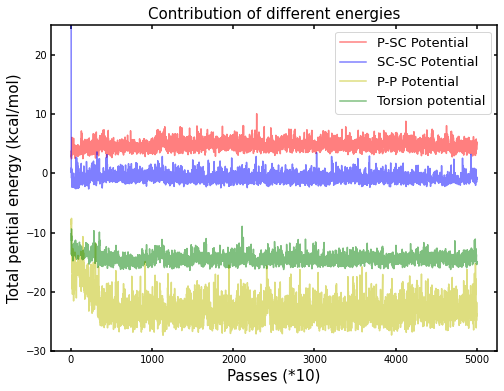

In [478]:
fig = plt.figure(figsize=(8,6))
ax = fig.gca()
ax.tick_params(which='both',top='on',left = 'on', right = 'on', bottom ='on',direction='in',width = 1.5)
ax.spines["right"].set_linewidth(1.5)
ax.spines["left"].set_linewidth(1.5)
ax.spines["top"].set_linewidth(1.5)
ax.spines["bottom"].set_linewidth(1.5)
#plt.plot(record_energy,alpha = 0.4, color = 'k')
plt.plot(record_P1,alpha = 0.5, color = 'r', label = 'P-SC Potential')
plt.plot(record_P2,alpha = 0.5, color = 'b', label = 'SC-SC Potential')
plt.plot(record_P3,alpha = 0.5, color = 'y', label = 'P-P Potential')
plt.plot(record_P4,alpha = 0.5, color = 'g', label = 'Torsion potential')
plt.xlabel('Passes (*10)',fontsize = 15)
plt.ylabel("Total pential energy (kcal/mol)", fontsize = 15)
plt.legend(fontsize = 13,loc = 'best')
plt.ylim([-30,25])
plt.title('Contribution of different energies', fontsize = 15)
plt.savefig('figure1.3.pdf')
